<a href="https://colab.research.google.com/github/nlee98/ADS-505-Business-Analytics/blob/main/ADS_505_Final_Project_NL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airline Passenger Satisfaction

Nicholas Lee, Mohammad Mahmoudighaznavi and Christine Vu

Shiley-Marcos School of Engineering, University of San Diego

ADS 505: Applied Data Science for Business

Professor Dillon Orr

October 21, 2022

# Data Set Description
Data obtained from: https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction

| Variable | Description  |
| --- | --- |
| Unnamed: 0 | Index |
| id | Flight identification  |
| Gender | Gender of the passengers (Female, Male) |
| Customer Type | The customer type (Loyal customer, disloyal customer) |
| Age | The actual age of the passengers |
| Type of Travel | Purpose of the flight of the passengers (Personal Travel, Business Travel) |
| Class | Travel class in the plane of the passengers (Business, Eco, Eco Plus) |
| Flight distance | The flight distance of this journey |
| Inflight wifi service | Satisfaction level of the inflight wifi service (0: Not Applicable; 1-5) |
| Departure/Arrival time convenient | Satisfaction level of Departure/Arrival time convenient |
| Ease of Online booking | Satisfaction level of online booking |
| Gate location | Satisfaction level of Gate location |
| Food and drink | Satisfaction level of Food and drink |
| Online boarding | Satisfaction level of online boarding |
| Seat comfort | Satisfaction level of Seat comfort |
| Inflight entertainment | Satisfaction level of inflight entertainment |
| On-board service | Satisfaction level of On-board service |
| Leg room service | Satisfaction level of Leg room service |
| Baggage handling | Satisfaction level of baggage handling |
| Check-in service | Satisfaction level of Check-in service |
| Inflight service | Satisfaction level of inflight service |
| Cleanliness | Satisfaction level of Cleanliness |
| Departure Delay in Minutes | Minutes delayed when departure |
| Arrival Delay in Minutes | Minutes delayed when Arrival |
| Satisfaction | Airline satisfaction level (Satisfaction, neutral or dissatisfaction) |

In [2]:
!pip install dmba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 2.2 MB/s 


In [3]:
# Packages #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

from dmba import classificationSummary
from google.colab import files

warnings.filterwarnings("ignore")
%matplotlib inline

no display found. Using non-interactive Agg backend


In [4]:
# Import Data Sets via Upload
# uploaded = files.upload()

In [5]:
# # Import training set
# airline_train = pd.read_csv(
#     "airline_satisfaction_train.csv"
# )

# # Import test set
# airline_test = pd.read_csv(
#     "airline_satisfaction_test.csv"
# )

In [6]:
airline_train = pd.read_csv(
    "https://raw.githubusercontent.com/nlee98/ADS-505-Business-Analytics/main/airline_satisfaction_train.csv"
)
airline_test = pd.read_csv(
    "https://raw.githubusercontent.com/nlee98/ADS-505-Business-Analytics/main/airline_satisfaction_test.csv"
)

In [7]:
airline_train.head(3)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied


# Combine Files to One Data Set
The source had previously split the data into a training and a test set. However, the data is currently split 80:20 train:test. Because there is a large number of records, we would like to test our models with a 70:30 split.

In [8]:
airline_df = airline_train.append(airline_test, ignore_index = True)

# Confirm the correct number of rows and columns
print("Number of instances: %d" % (airline_df.shape[0]))
print("Number of attributes: %d" % (airline_df.shape[1]))

Number of instances: 129880
Number of attributes: 25


# ID Columns Removal
The columns "Unnamed: 0" and "id" hold no insights into the data; they are equivalent to the dataframe indeces. For that reason, the columns can be dropped early on, lessening the number of predictors explored during exploratory data analysis.

In [9]:
# Drop ID Columns
airline_df = airline_df.drop(["Unnamed: 0", "id"], axis = 1)

# Exploratory Data Analysis (EDA)

In [10]:
# Check predictor data types are as expected
airline_df.dtypes

Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
satisfacti

Of the 23 features, there are 22 predictors and one target variable, "satisfaction." Four categorical variables make up the 22 predictors; those are Gender, Customer Type, Type of Travel and Class. The other 18 predictors are based on a 5-point likert scale. More discussion on how these will be treated, either as ordinal or numerical, later on.

## Descriptive Statistics

In [11]:
# Key statistics of studied variables
airline_df.describe()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129487.000000
mean,39.427957,1190.316392,2.728696,3.057599,2.756876,2.976925,3.204774,3.252633,3.441361,3.358077,3.383023,3.350878,3.632114,3.306267,3.642193,3.286326,14.713713,15.091129
std,15.119360,997.452477,1.329340,1.526741,1.401740,1.278520,1.329933,1.350719,1.319289,1.334049,1.287099,1.316252,1.180025,1.266185,1.176669,1.313682,38.071126,38.465650
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,844.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


## Missing Values

In [12]:
# Check for missing values in the data set
print(airline_df.isnull().sum())

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction                           0
dtype: int64


There are 393 missing values, all in the predictor "Arrival Delay in Minutes."

### Class Proportions

In [13]:
airline_df["satisfaction"].value_counts()/airline_df.shape[0] * 100

neutral or dissatisfied    56.553742
satisfied                  43.446258
Name: satisfaction, dtype: float64

The data is not imbalanced. 56.55% of the records is neutral or dissatisfied and the remaining 43.45% is satisfied.

## Categorical Predictors ##

### Barcharts of Customers by Gender and Customer Type 

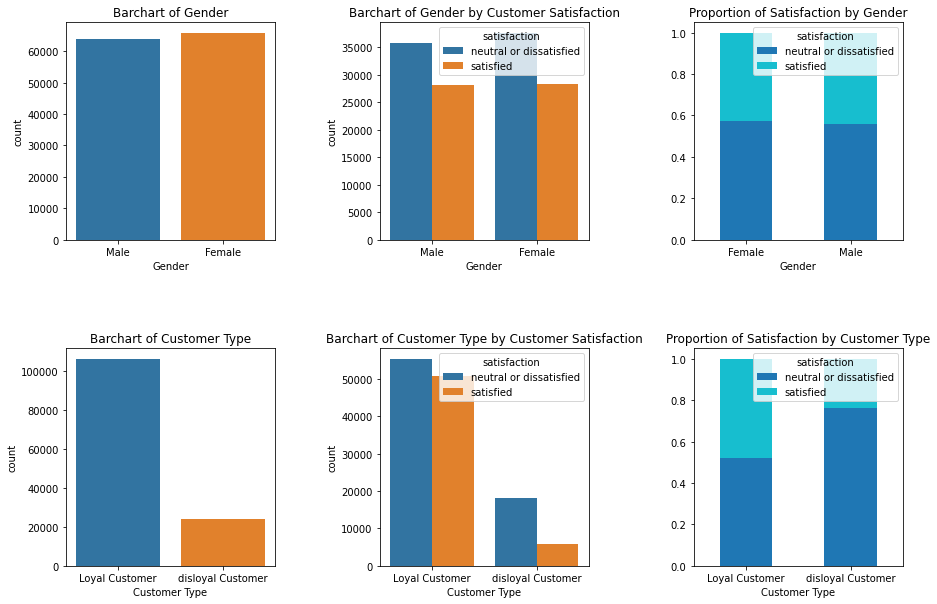

In [14]:
fig, axes = plt.subplots(
    nrows = 2,
    ncols = 3,
    figsize = (15, 10)
)

# Count of Each Gender
plt.subplot(2,3,1)
sns.countplot(x = airline_df["Gender"])
plt.title("Barchart of Gender")

# Satisfaction Rating by Gender
plt.subplot(2,3,2)
sns.countplot(x = airline_df["Gender"],
              hue = airline_df["satisfaction"]);
plt.title("Barchart of Gender by Customer Satisfaction")

# Proportion of Satisfaction Rating by Gender
gender_crosstab = pd.crosstab(airline_df["Gender"], airline_df["satisfaction"])
gender_proptab = gender_crosstab.div(gender_crosstab.sum(axis = 1), axis = 0)
gender_proptab.plot(kind = "bar", stacked = True,
                    colormap = "tab10",
                    ax = axes[0,2], rot = 0,
                    title = "Proportion of Satisfaction by Gender")

# Countplot of Customer Type
plt.subplot(2,3,4)
sns.countplot(x = airline_df["Customer Type"])
plt.title("Barchart of Customer Type")

# Count of Satisfaction Rating by Customer Type
plt.subplot(2,3,5)
sns.countplot(x = airline_df["Customer Type"],
              hue = airline_df["satisfaction"])
plt.title("Barchart of Customer Type by Customer Satisfaction")

# Propotion of Satisfaction by Customer Type
cust_proptab = pd.crosstab(index = airline_df["Customer Type"],
                           columns = airline_df["satisfaction"],
                           normalize = "index")
cust_proptab.plot(kind = "bar", stacked = True,
                  colormap = "tab10",
                  ax = axes[1,2], rot = 0,
                  title = "Proportion of Satisfaction by Customer Type")

fig.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

There is roughly the same number of males and females. Within each gender category, there is roughly the same number of neural/dissatisfied and satisfied customers. Thus, based on the plots, gender does not appear to be influencing the outcome variable.

In the data set, there are a lot more loyal customers than disloyal customers. Through the normalized bar chart of satisfaction ratings by customer type, there is a higher proportion of neutral or dissatisfied customers among disloyal customers than there are among loyal customers. This chart provides us with the initial insight that perhaps customer loyalty may affect satisfaction ratings.

### Barcharts of Type of Travel and (Ticket) Class 

satisfaction     neutral or dissatisfied  satisfied
Type of Travel                                     
Business travel                 0.416276   0.583724
Personal Travel                 0.898674   0.101326 

satisfaction  neutral or dissatisfied  satisfied
Class                                           
Business                     0.305566   0.694434
Eco                          0.812327   0.187673
Eco Plus                     0.753586   0.246414


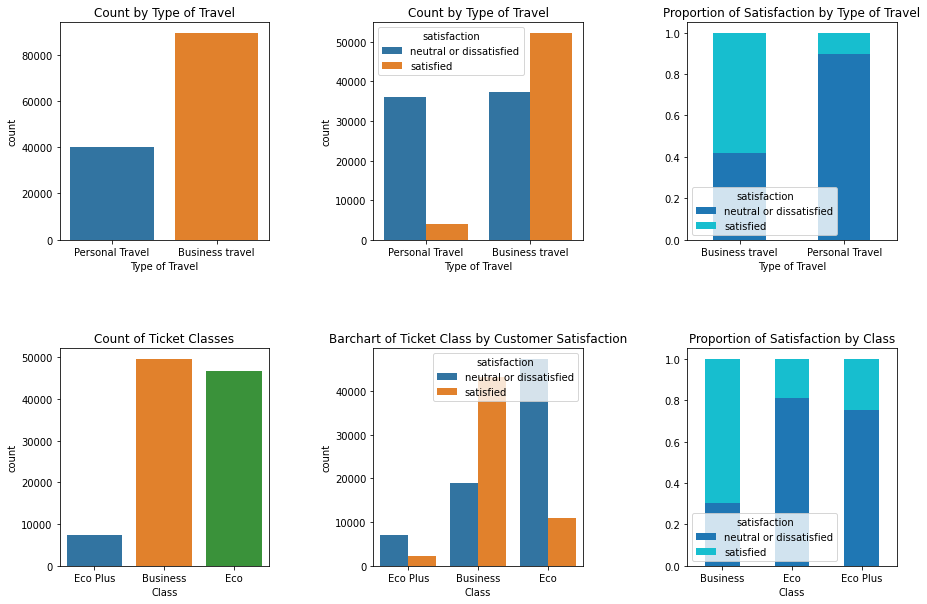

In [15]:
fig, axes = plt.subplots(
    nrows = 2,
    ncols = 3,
    figsize = (15, 10)
)
# Count Plot of Type of Travel
plt.subplot(2,3,1)
sns.countplot(x = airline_df["Type of Travel"])
plt.title("Count by Type of Travel")

# Count Plot of Satisfaction Rating by Type of Travel
plt.subplot(2,3,2)
sns.countplot(x = airline_df["Type of Travel"],
              hue = airline_df["satisfaction"])
plt.title("Count by Type of Travel")

# Proportion of satisfaction by Type of Travel
travel_proptab = pd.crosstab(index = airline_df["Type of Travel"],
                           columns = airline_df["satisfaction"],
                           normalize = "index")
travel_proptab.plot(kind = "bar", stacked = True,
                  colormap = "tab10",
                  ax = axes[0,2], rot = 0,
                  title = "Proportion of Satisfaction by Type of Travel")

# Count Plot of (Ticket) Class predictor
plt.subplot(2,3,4)
sns.countplot(x = airline_train["Class"])
plt.title("Count of Ticket Classes")

# Count Plot of Satisfaction Rating by (Ticket) Class
plt.subplot(2,3,5)
sns.countplot(x = airline_df["Class"],
              hue = airline_df["satisfaction"])
plt.title("Barchart of Ticket Class by Customer Satisfaction")

# Proportion of satisfaction by (Ticket) Class
class_proptab = pd.crosstab(index = airline_df["Class"],
                           columns = airline_df["satisfaction"],
                           normalize = "index")
class_proptab.plot(kind = "bar", stacked = True,
                  colormap = "tab10",
                  ax = axes[1,2], rot = 0,
                  title = "Proportion of Satisfaction by Class")

print(travel_proptab, "\n")
print(class_proptab)

fig.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

The data set contains nearly double the number of business travelers than personal travel records. Among those travelling for business, just slightly over 40% (41.63%, exactly) are neutral or dissatisfied with the flight, while the other 58.37% are satisfied. However, amonng those travelling for personal reasons, nearly all are neutral or dissatisfied (89.86%), while the only 10% of personal travellers are satisfied with the flight.

Based on ticket class, business, economy, or economy plus, the class with the highest proportion of neutral/dissatisfied customers is the economy class (81.23%), where business class customers had the lowest proportion of dissatisfied customers (30.56%).

### Ratings by Service

In [91]:
# Services that can be rated
rating_feat = [
    "Inflight wifi service", "Departure/Arrival time convenient",
    "Ease of Online booking", "Gate location",
    "Food and drink", "Online boarding",
    "Seat comfort", "Inflight entertainment",
    "On-board service", "Leg room service",
    "Baggage handling", "Checkin service",
    "Inflight service", "Cleanliness"
]
def rating_count(dataframe):
  # Rating Scores Dataframe (i.e. number of 2s for Cleanliness)
  rating_feat_df = pd.DataFrame()
  for service in rating_feat:
    service_ratings = pd.DataFrame(
        dataframe[service].value_counts().sort_index(), columns = [service]
   )
    rating_feat_df[service] = service_ratings[service]

  rating_feat_df["Ratings"] = ["0", "1", "2", "3", "4", "5"]

  # Replace any missing values with 0
  rating_feat_df = rating_feat_df.fillna(0)

  return rating_feat_df

def rating_proportions(dataframe):
  # Identify the proportion of ratings per service
  # (i.e. 20% of 0s come from Inflight wifi service)
  rating_prop_df = dataframe.drop(["Ratings"], axis = 1)
  rating_prop_df["Baggage handling"] = rating_prop_df["Baggage handling"].astype("int64")
  rating_prop_df = rating_prop_df.div(rating_prop_df.sum(axis = 1), axis = 0)
  
  # Add Ratings Columns
  rating_prop_df["Ratings"] = dataframe["Ratings"]

  return rating_prop_df

In [102]:
all_cust_ratings = rating_count(airline_df[rating_feat])
all_cust_prop = rating_proportions(all_cust_ratings)

# Dissatisfied Customers
dissatisfied_df = airline_df.loc[airline_df["satisfaction"] == "neutral or dissatisfied"]
dissatisfied_ratings = rating_count(dissatisfied_df)
dissatisfied_prop = rating_proportions(dissatisfied_ratings)

# Satisfied Customers
satisfied_df = airline_df.loc[airline_df["satisfaction"] == "satisfied"]
satisfied_ratings = rating_count(satisfied_df)
satisfied_prop = rating_proportions(satisfied_ratings)

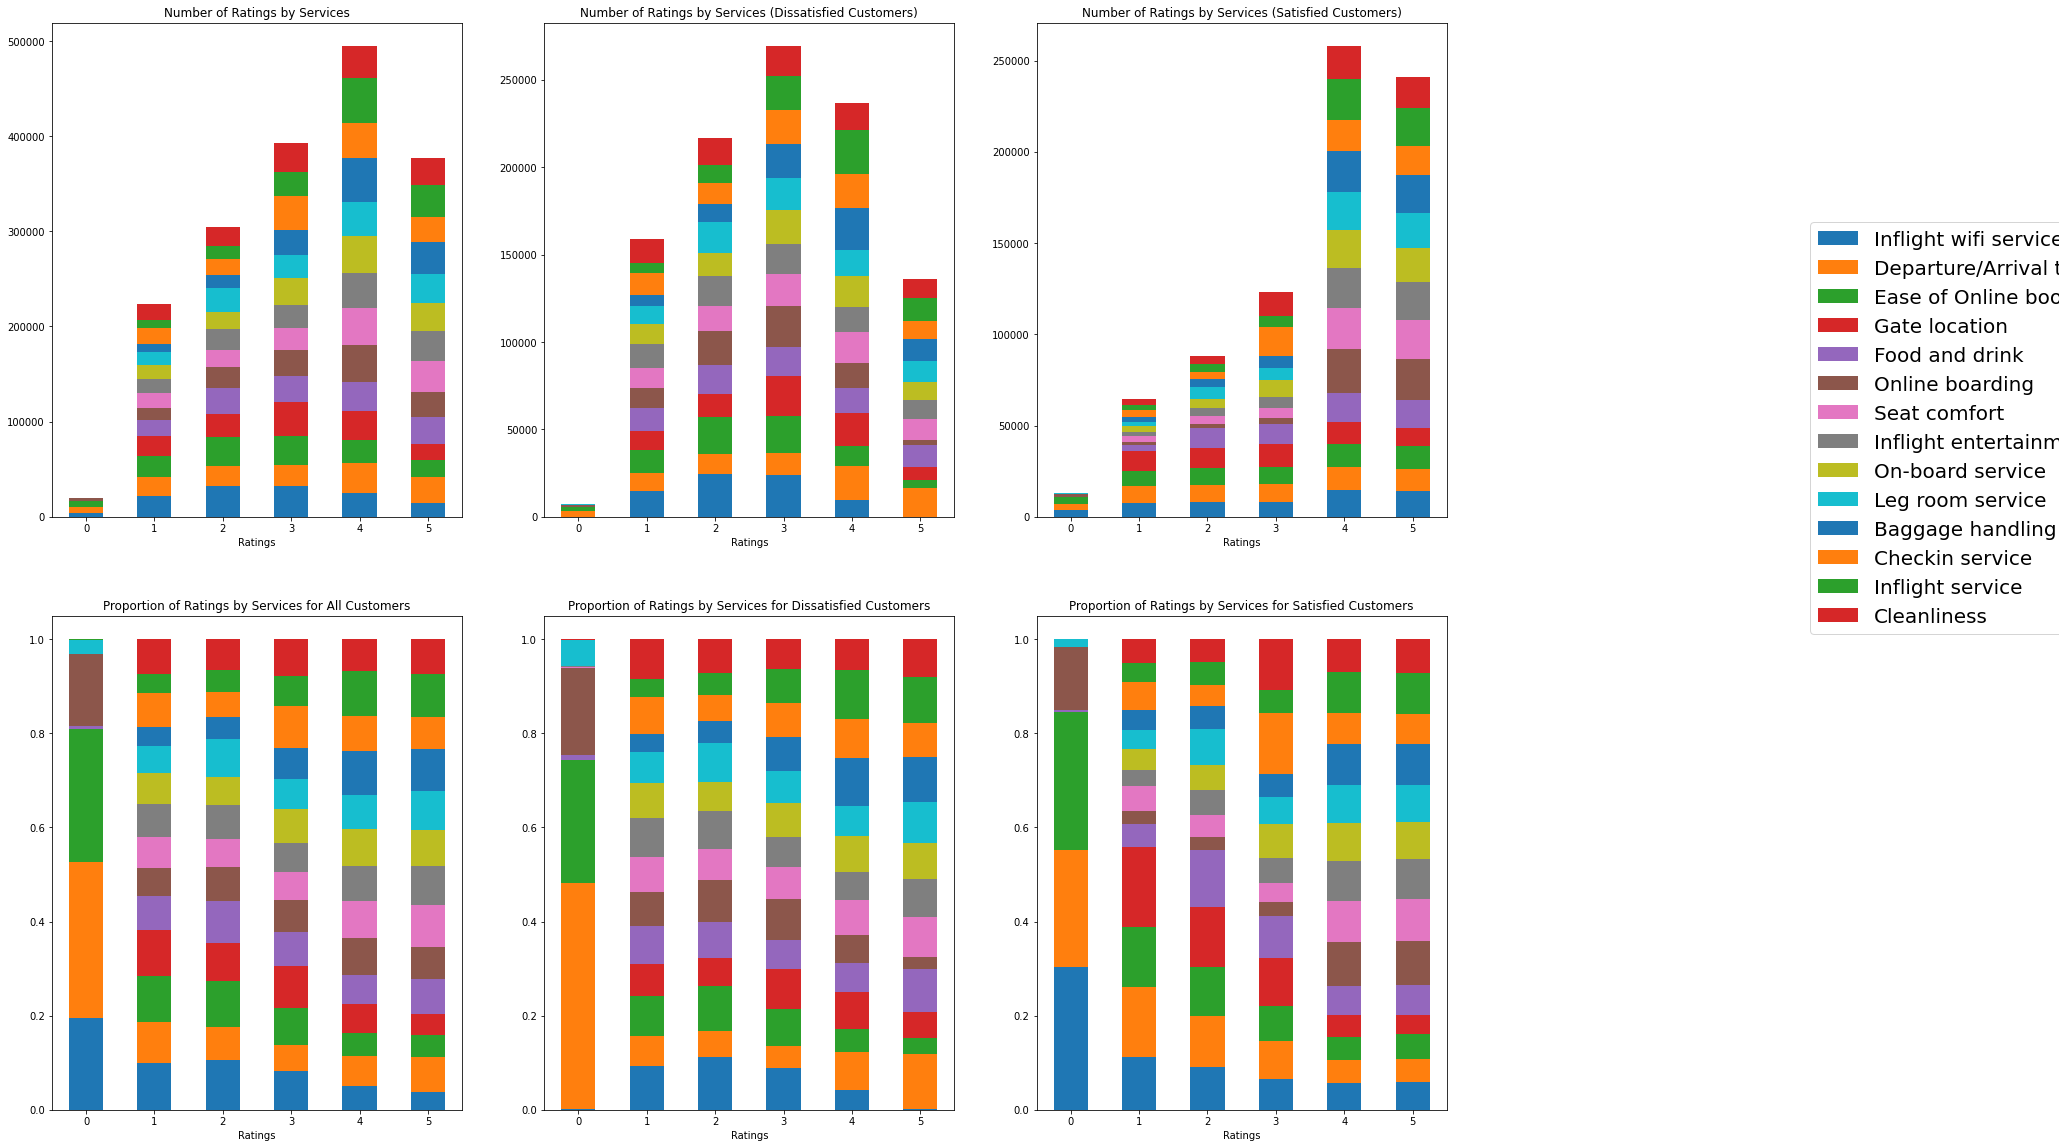

In [121]:
# Plot Count of Ratings by Services
fig, axes = plt.subplots(
    nrows = 2,
    ncols = 3,
    figsize = (25, 20)
)

# All Customers Plot
all_cust_ratings.plot(
    x = "Ratings",
    kind='bar', stacked=True,
    rot = 0,
    title = "Number of Ratings by Services",
    ax = axes[0,0], legend = False
)
fig.legend(loc = "center left", bbox_to_anchor = (1.0, 0.5),
           prop={'size': 20})

# All Customers - Proportions of Ratings By Service
all_cust_prop.plot(
    x = "Ratings",
    kind='bar', stacked=True,
    rot = 0,
    title = "Proportion of Ratings by Services for All Customers",
    ax = axes[1,0], legend = False
)

# Dissatisfied Customers
dissatisfied_ratings.plot(
    x = "Ratings",
    kind='bar', stacked=True,
    rot = 0,
    title = "Number of Ratings by Services (Dissatisfied Customers)",
    ax = axes[0,1], legend = False
)

dissatisfied_prop.plot(
    x = "Ratings",
    kind='bar', stacked=True,
    rot = 0,
    title = "Proportion of Ratings by Services for Dissatisfied Customers",
    ax = axes[1,1], legend = False
)

# Satisfied Customers
satisfied_ratings.plot(
    x = "Ratings",
    kind='bar', stacked=True,
    rot = 0,
    title = "Number of Ratings by Services (Satisfied Customers)",
    ax = axes[0,2], legend = False
)

satisfied_prop.plot(
    x = "Ratings",
    kind='bar', stacked=True,
    rot = 0,
    title = "Proportion of Ratings by Services for Satisfied Customers",
    ax = axes[1,2], legend = False
)

plt.show()

## Numerical Predictors

### Histogram of All Numerical Features ###

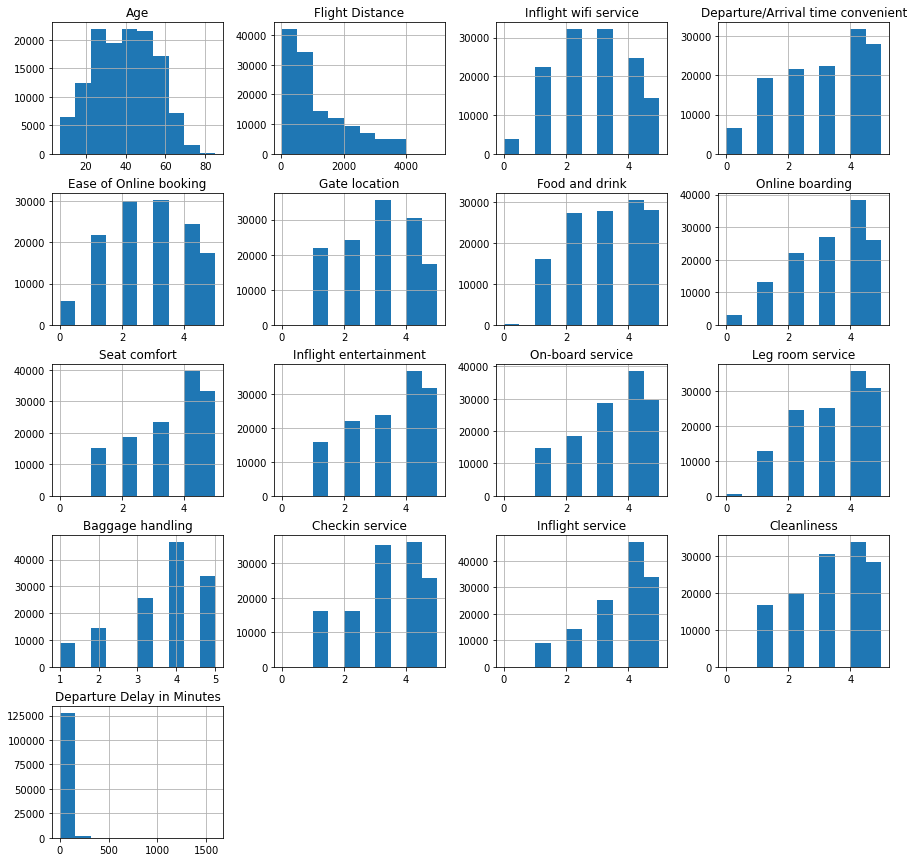

In [17]:
airline_df.select_dtypes(include = "int64").hist(figsize = (15, 15));

Many of predictors are ordinal in nature, falling on a ranking scale from 1 to 5. There is much debate about how to handle these variables. From a practical perspective, customers are ranking each predictor on a scale. Thus, there is a strong argument to treat them as ordinal variables. However, Sullivan and Artino Jr. (2013) stated that treating these predictors as numerical yields more robust results. In addition, treating the 5-point scale as numerical retains the underlying relationship that an increase in value corresponds to an increase in customer satisfaction with the predictor. For that reason, the predictors on a 5-point likert scale will be treated as numerical.

**Reference**
Sullivan, G. M., & Artino Jr, A. R. (2013). Analyzing and interpreting data from Likert-type scales. _Journal of graduate medical education, 5_(4), 541-542.
https://meridian.allenpress.com/jgme/article/5/4/541/34037/Analyzing-and-Interpreting-Data-From-Likert-Type

### Distribution of Age

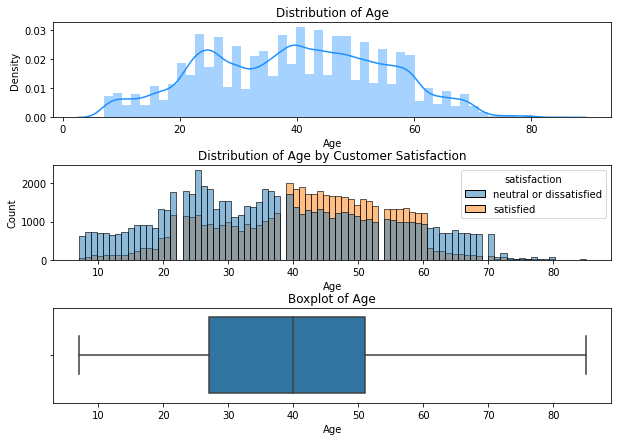

The median age is 40.0000
The average age is 39.4280


In [18]:
fig, axes = plt.subplots(
    nrows = 3,
    ncols = 1,
    figsize = (10, 7)
)

plt.subplot(3,1,1)
sns.distplot(airline_df["Age"],
             color = "dodgerblue")
plt.title("Distribution of Age")

plt.subplot(3,1,2)
sns.histplot(x = airline_df["Age"],
            hue = airline_df["satisfaction"]);
plt.title("Distribution of Age by Customer Satisfaction")

plt.subplot(3,1,3)
sns.boxplot(airline_df["Age"])
plt.title("Boxplot of Age")

fig.subplots_adjust(hspace = 0.5)
plt.show()

# Descriptive Statistics to Assess Normality
age_median = np.median(airline_df["Age"])
age_avg = np.average(airline_df["Age"])
print("The median age is %.4f" % age_median)
print("The average age is %.4f" % age_avg)

The histogram of age suggests that there may be some underlying predictor for customer satisfaction based on how old the customer is. For example, customers under the age of 39 or 40 appear to have more neural/disatisfied customers than satisfied customers. Customers between the ages of 40 and 60 appear to be  more satisfied than dissatisfied.

### Distribution of Numerical (non-likert scale) Predictors
Predictors: Flight Distance, Departure Delay, Arrival Delay

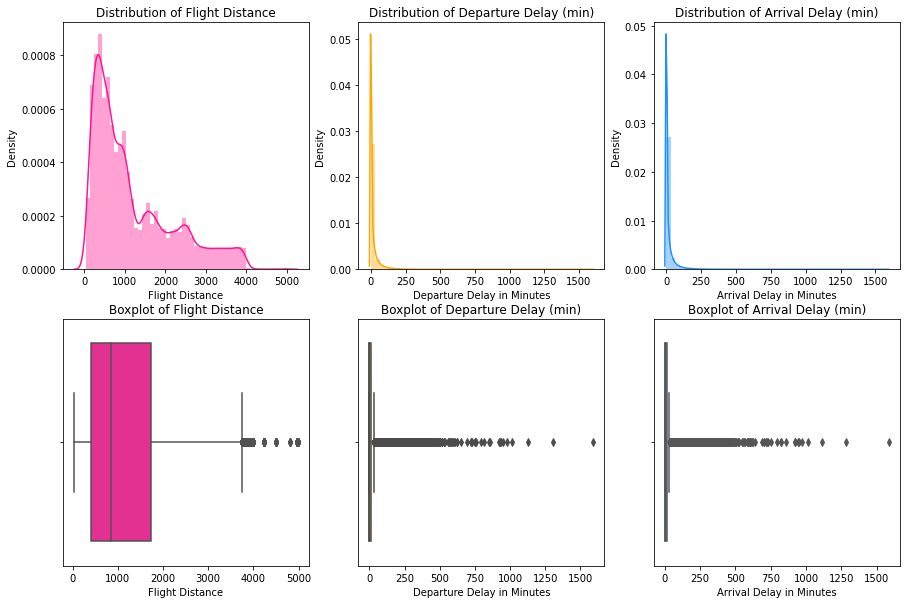

In [19]:
# Histogram of Flight Distance
fig, axes = plt.subplots(
    nrows = 2,
    ncols = 3,
    figsize = (15, 10)
)

# Flight Distance
plt.subplot(2,3,1)
sns.distplot(airline_df["Flight Distance"],
             color = "deeppink")
plt.title("Distribution of Flight Distance")

plt.subplot(2,3,4)
sns.boxplot(airline_df["Flight Distance"],
            color = "deeppink")
plt.title("Boxplot of Flight Distance")

# Departure Delay
plt.subplot(2,3,2)
sns.distplot(airline_df["Departure Delay in Minutes"],
             color = "orange")
plt.title("Distribution of Departure Delay (min)")

plt.subplot(2,3,5)
sns.boxplot(airline_df["Departure Delay in Minutes"],
            color = "orange")
plt.title("Boxplot of Departure Delay (min)")

# Arrival Delay
plt.subplot(2,3,3)
sns.distplot(airline_df["Arrival Delay in Minutes"],
             color = "dodgerblue")
plt.title("Distribution of Arrival Delay (min)")

plt.subplot(2,3,6)
sns.boxplot(airline_df["Arrival Delay in Minutes"],
            color = "dodgerblue")
plt.title("Boxplot of Arrival Delay (min)")

plt.show()

The features above are skewed right. The departure and arrival delay (in minutes) predictors are heavily skewed right due to the few instance in which flights were severely deplayed. It is important to keep all instances as heavy delays may be an indicator for satisfaction rating. Thus, before removal of outliers, transformations will be appleid to try to resolve skewness.

### Log + 1 Transformation of Numerical Predictors

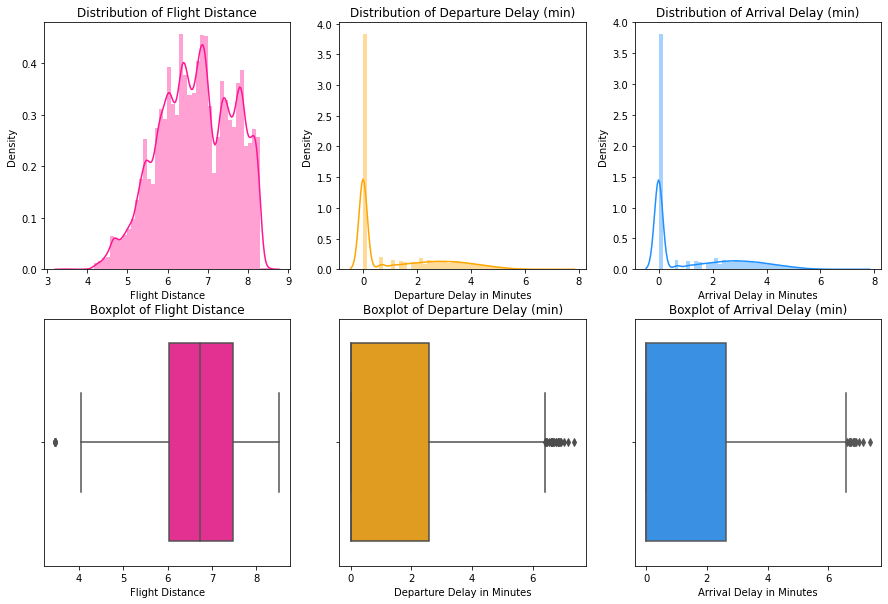

In [20]:
# Histogram of Flight Distance
fig, axes = plt.subplots(
    nrows = 2,
    ncols = 3,
    figsize = (15, 10)
)

# Flight Distance
plt.subplot(2,3,1)
sns.distplot(np.log(airline_df["Flight Distance"] + 1),
             color = "deeppink")
plt.title("Distribution of Flight Distance")

plt.subplot(2,3,4)
sns.boxplot(np.log(airline_df["Flight Distance"] + 1),
            color = "deeppink")
plt.title("Boxplot of Flight Distance")

# Departure Delay
plt.subplot(2,3,2)
sns.distplot(np.log(airline_df["Departure Delay in Minutes"] + 1),
             color = "orange")
plt.title("Distribution of Departure Delay (min)")

plt.subplot(2,3,5)
sns.boxplot(np.log(airline_df["Departure Delay in Minutes"] + 1),
            color = "orange")
plt.title("Boxplot of Departure Delay (min)")

# Arrival Delay
plt.subplot(2,3,3)
sns.distplot(np.log(airline_df["Arrival Delay in Minutes"] + 1),
             color = "dodgerblue")
plt.title("Distribution of Arrival Delay (min)")

plt.subplot(2,3,6)
sns.boxplot(np.log(airline_df["Arrival Delay in Minutes"] + 1),
            color = "dodgerblue")
plt.title("Boxplot of Arrival Delay (min)")

plt.show()

A Log plus one transformation resolved many of the outlier issues for the delay time predictors, leaving only a handful left. The transformation also corrected all but one data point, on the lower end, for the predictor Flight Distance.

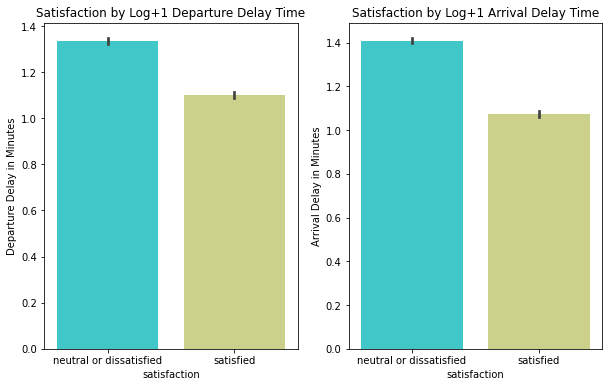

In [21]:
# Satisfaction Ratings by Delay Time
fig, axes = plt.subplots(
    nrows = 1,
    ncols = 2,
    figsize = (10,6)
)

# Satisfaction by Departure Delay
delay_log_one = np.log(airline_df["Departure Delay in Minutes"] + 1)
plt.subplot(1,2,1)
sns.barplot(x = "satisfaction",
            y = delay_log_one,
            data = airline_df,
            palette = "rainbow")
plt.title("Satisfaction by Log+1 Departure Delay Time")

# Satisfaction by Arrival Delay
arrive_log_one = np.log(airline_df["Arrival Delay in Minutes"] + 1)
plt.subplot(1,2,2)
sns.barplot(x = "satisfaction",
            y = arrive_log_one,
            data = airline_df,
            palette = "rainbow")
plt.title("Satisfaction by Log+1 Arrival Delay Time")

plt.show()

### Correlation Matrix

In [22]:
airline_df.dtypes

Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
satisfacti

In [23]:
# Transform Flight Distance, Departure Delay in Minutes, and Arrival Delay in Minutes
airline_df["Departure Delay Log+1 Transformed"] = delay_log_one
airline_df["Arrival Delay Log+1 Transformed"] = arrive_log_one
airline_df["Flight Distance Log+1 Transformed"] = np.log(airline_df["Flight Distance"] + 1)

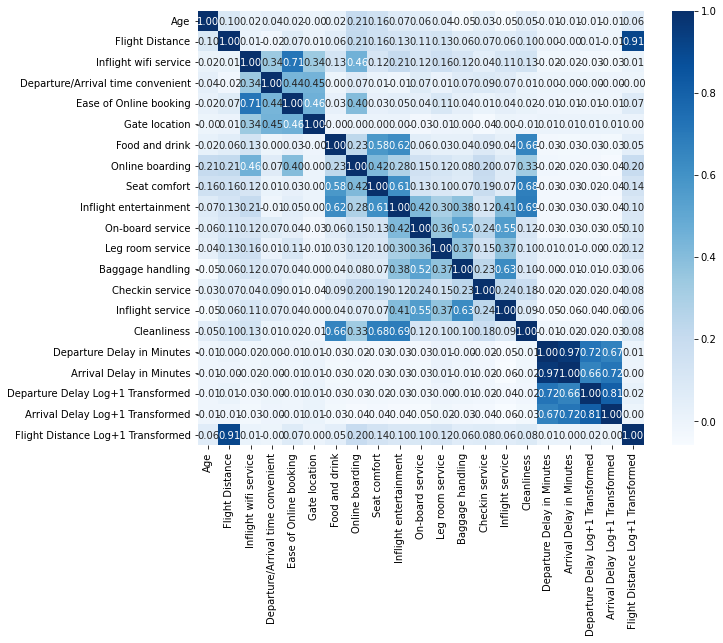

In [24]:
# Isolate Numerical Predictors
numerical_col = airline_df.select_dtypes(include = ["int64", "float64"]).columns.tolist()
num_corr = airline_df[numerical_col].corr()

# Heatmap of Correlation Matrix
plt.figure(figsize = (10,8))
sns.heatmap(num_corr, annot = True,
            fmt = ".2f", 
            cmap = "Blues");
plt.show()

The correlation matrix shows that the highest degree of correlation is between the the transformed departure and arrival delay time predictors (correlation coefficient of 0.81).

The correlation between flight distance and its transformed equivalent can be ignored, as only the transformed version of the predictor will be taken into the modeling step.

In [25]:
numerical_pred = airline_df.select_dtypes(include = ["int64", "float64"])

# Remove Untransformed predictors
numerical_pred = numerical_pred.drop(["Flight Distance", "Departure Delay in Minutes", 
                                      "Arrival Delay in Minutes"], axis = 1)

# Remove NaNs for Variance Inflaction Factor (VIF) Calculation
numerical_pred = numerical_pred.dropna(axis = 0)

pd.Series([variance_inflation_factor(numerical_pred.values, i) 
               for i in range(numerical_pred.shape[1])], 
              index = numerical_pred.columns)


Age                                   7.959273
Inflight wifi service                12.308712
Departure/Arrival time convenient     7.191163
Ease of Online booking               12.872308
Gate location                         9.255638
Food and drink                       14.203102
Online boarding                      12.648590
Seat comfort                         18.564052
Inflight entertainment               26.903170
On-board service                     13.903111
Leg room service                      9.687972
Baggage handling                     19.484805
Checkin service                       9.420149
Inflight service                     21.182120
Cleanliness                          20.430449
Departure Delay Log+1 Transformed     4.560478
Arrival Delay Log+1 Transformed       4.604697
Flight Distance Log+1 Transformed    27.170917
dtype: float64

Dormann et al. (2013) suggest a correlation coefficient threshold of 0.7 and greater or -0.7 and lower, as markers for collinearity issues. Another metric for collinearity issues is the variance inflation factor (VIF). O'brien (2007) warns against utilizing the generally accepted rule that VIF values above 10 should indicate predictors to remove.

Using the correlation coefficient threshold, all delay predictors (Departure Delay Time Log+1 Transformed and Arrival Delay Time Log+1 Transformed) should be removed. However, the VIF factors for those predictors are below the generally accepted rule. Common knowledge would suggest that a greater delay would lead to increased dissatisfaction ratings. Therefore, predictors associated to delay times should not be removed as they can be an important predictor.

Many other predictors have VIF values above 10. However, O'brien (2007) states that "VIF of 10, 20, 40, or even higher do not, by themselves, discount the results of ... analyses \[or] call for the elimination of one or more independent variables from the analysis." In this data set, predictors that have VIF values greater than 10 are not correlated to other predictors with a correlation coefficient greater than 0.7 or less than -0.7. Therefore, it was deemed appropriate to keep all predictors.

**References**
Dormann, C. F., Elith, J., Bacher, S., Buchmann, C., Carl, G., Carré, G., ... & Lautenbach, S. (2013). _Collinearity: a review of methods to deal with it and a simulation study evaluating their performance. Ecography, 36_(1), 27-46.

O’brien, R. M. (2007). A caution regarding rules of thumb for variance inflation factors. _Quality & quantity, 41_(5), 673-690.

# Pre-Processing #

### Removing Missing Values 

In [26]:
# Resolve Missing Values in Arrival Delay in Minutes
airline_df = airline_df.dropna(axis = 0)

Mears et al. (n.d.) states that if missing value makes up less than 5% of the data, it is acceptable to remove the missing values. There are only 393 missing values in Arrival Delay in Miutes, out of 129,800 records. The total number of missing values is 0.3% of the total number of records. Given the rule set by Mears et al., it is safe to remove the instances with missing values from the data set.

**Reference**

Mears, K., Montelpare, W. J., Read, E., McComber, T., Mahar, A., & Ritchie, K. (n.d.). Working with missing data. Applied Statistics in Healthcare Research. Retrieved September 24, 2022, from https://pressbooks.library.upei.ca/montelpare/chapter/working-with-missing-data/#:~:text=How%20much%20data%20is%20missing%3F,to%20which%20data%20is%20missing.

In [27]:
# Drop untransformed numerical predictors
airline_df = airline_df.drop(
    ["Flight Distance", "Departure Delay in Minutes",
     "Arrival Delay in Minutes"], axis = 1
)

## Dummy Encoding Predictors 

In [28]:
# Dummy Encode Gender, Customer Type, Type of Travel, Class
# Convert categorical predictors from Object to Category type
categorical_feat = ["Gender", "Customer Type",
                    "Type of Travel", "Class"]

airline_df[categorical_feat] = airline_df[categorical_feat].astype("category")

# Dummy Variables
dummy_pred = pd.get_dummies(airline_df[categorical_feat], drop_first = True)

# Drop un-encoded categorical predictors
airline_df_no_cat_feat = airline_df.drop(categorical_feat, axis = 1)

# Add Dummies to the dataframe
airline_encoded = pd.concat([airline_df_no_cat_feat, dummy_pred], axis = 1)

airline_encoded.shape

(129487, 24)

## Encode Outcome Variable

In [29]:
airline_encoded["satisfaction"] = airline_encoded["satisfaction"].map(
    {"neutral or dissatisfied" : 0, "satisfied" : 1})

airline_encoded["satisfaction"].value_counts()

0    73225
1    56262
Name: satisfaction, dtype: int64

In [30]:
# Confirm All Columns are Correct
airline_encoded.columns

Index(['Age', 'Inflight wifi service', 'Departure/Arrival time convenient',
       'Ease of Online booking', 'Gate location', 'Food and drink',
       'Online boarding', 'Seat comfort', 'Inflight entertainment',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Inflight service', 'Cleanliness', 'satisfaction',
       'Departure Delay Log+1 Transformed', 'Arrival Delay Log+1 Transformed',
       'Flight Distance Log+1 Transformed', 'Gender_Male',
       'Customer Type_disloyal Customer', 'Type of Travel_Personal Travel',
       'Class_Eco', 'Class_Eco Plus'],
      dtype='object')

## Splitting into Training and Test Sets

In [31]:
# Split into Training and Test Sets
x_data = airline_encoded.drop(["satisfaction"], axis = 1)
y_data = airline_encoded["satisfaction"]

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size = 0.3, random_state = 1
)

## Creating Scaled Versions of the Predictors

In [32]:
# Create Scaled Versions of Data Sets

# MinMaxScaler - Preserves original distribution
minmax_scale = MinMaxScaler()
x_train_minmaxscale = minmax_scale.fit_transform(x_train)
x_test_minmaxscale = minmax_scale.transform(x_test)

# Standard Scaler - Normal Distribution
stand_scale = StandardScaler()
x_train_scaled = stand_scale.fit_transform(x_train)
x_test_scaled = stand_scale.transform(x_test)

# Model Training

## Decision Tree ##

## Random Forest ##

## Logistic Regression ##

## Linear Discriminant Analysis ##

Linear Discriminant Analysis (LDA) is a suitable method for distinguishing between the two classes as the model would not suffer from an issue of singularity, as the number of predictors is far below the number of records (Tharwat, 2016).

LDA assumes that predictors are "from a multivariate normal distribution" (Shmueli et al., 2020, p. 323). Seen through the distribution plots above, many of the features are not normally distributed. However, Shmueli et al. also states that LDA remains a robust method for classification even if the assumption for normality is violated. In addition, LDA can be used for ranking feature importance. To do so, predictors must be normalized

**References**

Shmueli, G., Bruce, P. C., Yahav, I., Patel, N. R., & Lichtendahl Jr, K. C. (2020). _Data mining for business analytics: concepts, techniques, and applications in Python_. John Wiley & Sons.

Tharwat, A. (2016). _Linear vs. quadratic discriminant analysis classifier: a tutorial. International Journal of Applied Pattern Recognition, 3_(2), 145-180.

In [33]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(x_train_scaled, y_train)

lda_train_pred = lda_model.predict(x_train_scaled)

classificationSummary(y_train, lda_train_pred)
print("\nIntercept: ", lda_model.intercept_)
print("Coefficients: ", lda_model.coef_)

Confusion Matrix (Accuracy 0.8719)

       Prediction
Actual     0     1
     0 46216  5152
     1  6458 32814

Intercept:  [-0.60858928]
Coefficients:  [[-0.14525092  0.82686222 -0.24129092 -0.52382646  0.04791561 -0.06047283
   0.9903279   0.07855992  0.19149532  0.41407584  0.39538755  0.16953318
   0.42355761  0.14974051  0.32379464  0.05898168 -0.36768353 -0.02382434
   0.04620343 -1.11558204 -1.63277949 -0.57578611 -0.32736826]]


In [122]:
lda_scores = cross_val_score(lda_model, x_train_scaled, y_train, cv = 10)
print(lda_scores)
print("The 10-fold cross validated model has a",
      "%0.2f accuracy with a standard deviation of %0.2f" % 
      (lda_scores.mean(), lda_scores.std()))

[0.86915269 0.8770962  0.8712489  0.87356575 0.86893204 0.87544131
 0.87643425 0.86937335 0.86860106 0.86738747]
0.87 accuracy with a standard deviation of 0.00


10-fold cross-validation confirms the accuracy obtained on the training set, without crossfold validation.

In [35]:
lda_coef_df = pd.DataFrame({
    "Features" : x_data.columns.tolist(),
    "Coefficients" : lda_model.coef_.ravel(),
    "ABSCoefficients" : np.abs(lda_model.coef_.ravel())
}).sort_values(by = ["ABSCoefficients"], ascending = False).drop(["ABSCoefficients"], axis = 1)

print(lda_coef_df.head(5))
print(lda_coef_df.tail(5))

                           Features  Coefficients
20   Type of Travel_Personal Travel     -1.632779
19  Customer Type_disloyal Customer     -1.115582
6                   Online boarding      0.990328
1             Inflight wifi service      0.826862
21                        Class_Eco     -0.575786
                             Features  Coefficients
5                      Food and drink     -0.060473
15  Departure Delay Log+1 Transformed      0.058982
4                       Gate location      0.047916
18                        Gender_Male      0.046203
17  Flight Distance Log+1 Transformed     -0.023824


Liu et al. (2022) ranked the importance of their predictors by the absolute magnitude of the coefficients of the LDA model. Applying the same rationale, the top five most impactful predictors are (in descending order): Type of travel_Personal Travel, Customer Type_disloyal Customer, Online boarding, Inflight wifi service, and Class_Eco. 

The five least influential predictors are: Food and drink, Departure Delay Log+1 Transformed, Gate location, Gender_Male, and Flight Distance Log+1 Transformed.

**Reference**

Liu, K., Ye, R., Zhongzhu, L., & Ye, R. (2022). Entropy-based discrimination between translated Chinese and original Chinese using data mining techniques. Plos one, 17(3), e0265633.

## Quadratic Discriminant Analysis

Quadratic Discriminant Analysis (QDA) does not assume that the classes share a covariance matrix (*cite). In addition, the decision boundaries are more flexible, and not forced to be linear as they are in LDA.

**Reference**
https://towardsdatascience.com/linear-discriminant-analysis-explained-f88be6c1e00b

In [36]:
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(x_train_scaled, y_train)

qda_train_pred = qda_model.predict(x_train_scaled)
classificationSummary(y_train, qda_train_pred)

Confusion Matrix (Accuracy 0.8602)

       Prediction
Actual     0     1
     0 46203  5165
     1  7502 31770


In [37]:
qda_score = cross_val_score(qda_model, x_train_scaled, y_train, cv = 10)
print(qda_score)
print("The 10-fold cross-validated model has a",
      "%0.2f accuracy with a standard deviation of %0.2f" 
      % (qda_score.mean(), qda_score.std()))

[0.86054722 0.86032657 0.85800971 0.86076787 0.85812004 0.86308473
 0.86385702 0.86109885 0.85723742 0.85734775]
0.86 accuracy with a standard deviation of 0.00


## Support Vector Machine (SVM)

In [125]:
from sklearn import svm
# Default kernel - Radial Basis Function (RBF)
svm_model = svm.SVC(random_state = 1)
svm_model.fit(x_train_scaled, y_train)
svm_train_pred = svm_model.predict(x_train_scaled)

classificationSummary(y_train, svm_train_pred)

Confusion Matrix (Accuracy 0.9588)

       Prediction
Actual     0     1
     0 50010  1358
     1  2378 36894


In [127]:
svm_linear_model = svm.SVC(kernel = "linear")
svm_linear_model.fit(x_train_scaled, y_train)

Confusion Matrix (Accuracy 0.9588)

       Prediction
Actual     0     1
     0 50010  1358
     1  2378 36894


In [128]:
svm_sigmoid_model = svm.SVC(kernel = "sigmoid")
svm_sigmoid_model.fit(x_train_scaled, y_train)

Confusion Matrix (Accuracy 0.9588)

       Prediction
Actual     0     1
     0 50010  1358
     1  2378 36894


In [129]:
svm_poly_model = svm.SVC(kernel = "poly")
svm_poly_model.fit(x_train_scaled, y_train)

Confusion Matrix (Accuracy 0.9588)

       Prediction
Actual     0     1
     0 50010  1358
     1  2378 36894


In [130]:
svm_linear_train_pred = svm_linear_model.predict(x_train_scaled)
print("SVM - Linear Kernel Confusion Matrix")
classificationSummary(y_train, svm_linear_train_pred)

svm_sigmoid_train_pred = svm_sigmoid_model.predict(x_train_scaled)
print("SVM - Sigmoid Kernel Confusion Matrix")
classificationSummary(y_train, svm_sigmoid_train_pred)

svm_poly_train_pred = svm_poly_model.predict(x_train_scaled)
print("SVM - Polynomial Kernel Confusion Matrix")
classificationSummary(y_train, svm_poly_train_pred)

Confusion Matrix (Accuracy 0.8774)

       Prediction
Actual     0     1
     0 46962  4406
     1  6703 32569
Confusion Matrix (Accuracy 0.7931)

       Prediction
Actual     0     1
     0 42031  9337
     1  9420 29852
Confusion Matrix (Accuracy 0.9465)

       Prediction
Actual     0     1
     0 49501  1867
     1  2985 36287


## Neural Network

# Test Set Performance

In [38]:
# Function to calculate confusion matrix performance metrics
# def model_performance(trained_model, x_test, y_test):
#     # Obtain predictions from the trained model
#     predictions = trained_model.predict(x_test)
    
#     # Obtain performance metrics
#     (tn, fp, fn, tp) = confusion_matrix(y_test, predictions).ravel()
    
#     # Performance metrics
#     accuracy = round((tn + tp) / (tn + fp + fn + tp), 4)
#     error_rate = round(1 - accuracy, 4)
#     sensitivity = round(tp / (tp + fn), 4)
#     specificity = round(tn / (tn + fp), 4)
#     precision = round(tp / (tp + fp), 4)
#     recall = sensitivity
#     f1_score = round(2 * ((precision * recall) / (precision + recall)), 4)
    
#     # Output
#     return {
#         "Accuracy" : accuracy, "Error_Rate" : error_rate, 
#         "Sensitivity" : sensitivity, "Specificity" : specificity, 
#         "Precision" : precision, "Recall" : recall, 
#         "F1-Score" : f1_score
#     }

In [39]:
# dtree_metrics = model_performance(tree_5split, x_test, y_test)
# randforest_metrics = model_performance(rand_forest_model, x_test, y_test)
# logreg_metrics = model_performance(logregcv_model, x_test_scale, y_test)
# nnet_metrics = model_performance(neural_net, x_test_minmaxscale, y_test)

# model_metrics = pd.DataFrame([
#     dtree_metrics, randforest_metrics,
#     logreg_metrics, nnet_metrics])
# model_metrics.insert(
#     loc = 0,
#     column = "Model",
#     value = ["Decision Tree", "Random Forest",
#             "Logistic Regression", "Neural Network"]
# )

# model_metrics